In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.layers import LeakyReLU, PReLU, ELU, ParametricSoftplus, ThresholdedLinear, ThresholdedReLU, SReLU

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.regularizers import l1, l2, l1l2
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras import backend as K

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

Using Theano backend.
Using gpu device 0: GeForce GTX 670 (CNMeM is disabled, CuDNN 4007)


In [2]:
categories = [
  'good_for_lunch', 
  'good_for_dinner', 
  'takes_reservations', 
  'outdoor_seating',
  'restaurant_is_expensive',
  'has_alcohol',
  'has_table_service',
  'ambience_is_classy',
  'good_for_kids'
]

vgg_cols = ['f' + str(i) for i in range(4096)]

In [3]:
data = pd.read_hdf('data/Xtrain_grouped.hdf5')
X, Y = np.array(data[vgg_cols]), np.array(data[categories])

random_state = np.random.RandomState(0)
Xtrain, Xval, ytrain, yval = train_test_split(X, Y, test_size=.2, random_state=random_state)
valset = (Xval, yval)

print Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

(1596, 4096) (400, 4096) (1596, 9) (400, 9)


In [4]:
mlb = MultiLabelBinarizer()
mlb.fit([(0,1,2,3,4,5,6,7,8)])

dataTest = None
for i in range(1, 7):
  part = pd.read_hdf('data/Xtest_grouped_part' + str(i) + '.hdf5', 'Xtest')
  print i, len(part)
  
  if dataTest is None:
    dataTest = part
  else:
    dataTest = dataTest.append(part)
    
Xtest = np.array(dataTest[vgg_cols])
Xtest.shape

1 1637
2 1707
3 1654
4 1746
5 1735
6 1521


(10000, 4096)

In [5]:
def loss(ytrue, ypred):
  return K.sum( (ytrue - ypred) ** 2 )

In [6]:
class f1stopperCallback(Callback):
  def __init__(self):
    self.bestf1val = 0

  def on_epoch_end(self, epoch, logs={}):
    pred = self.model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val = f1_score(yval, pred, average='micro')

    if f1_val > self.bestf1val:
      self.bestf1val = f1_val
      self.model.save_weights('models/tmp_weights.h5', overwrite=True)

# Train models

In [7]:
neurons = range(50, 501, 50)
dropout_vals = np.linspace(.1, .5, 5)
print neurons
print dropout_vals

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
[ 0.1  0.2  0.3  0.4  0.5]


In [8]:
def get_model(n_neurons, dropout_val):
  model = Sequential()
  np.random.seed(0)
  
  model.add(Dense(n_neurons, input_shape=(4096,), activation='softplus'))
  model.add(Dropout(dropout_val))

  model.add(Dense(9, activation='sigmoid'))
  model.compile(loss=loss, optimizer='adam')
  
  return model

In [9]:
models = []

for neu in neurons:
  for dro in dropout_vals:
    print neu, dro,
    model = get_model(neu, dro)
    
    model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=200)
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_last = f1_score(yval, pred, average='micro')
    
    model.load_weights('models/tmp_weights.h5')
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_best = f1_score(yval, pred, average='micro')
    
    print f1_val_last, f1_val_best
    
    models.append((f1_val_best, model))

50 0.1 0.824536376605 0.839407744875
50 0.2 0.825636719843 0.839831697055
50 0.3 0.82888004548 0.841687907108
50 0.4 0.828988828416 0.840915512857
50 0.5 0.830654420207 0.837592277115
100 0.1 0.824724809483 0.837446808511
100 0.2 0.827861832715 0.841865756542
100 0.3 0.831139095592 0.839021615472
100 0.4 0.828596037898 0.841782729805
100 0.5 0.840750069969 0.841927303466
150 0.1 0.825231481481 0.837276399308
150 0.2 0.828439838803 0.840157038699
150 0.3 0.834272829763 0.841722595078
150 0.4 0.8342760181 0.842706251784
150 0.5 0.837510560406 0.84246188594
200 0.1 0.825297787862 0.83917640512
200 0.2 0.826326471441 0.839582745983
200 0.3 0.82516671499 0.843907916901
200 0.4 0.835273573923 0.842017275007
200 0.5 0.831092928112 0.843475799604
250 0.1 0.818689391713 0.838111298482
250 0.2 0.820421490056 0.84007925276
250 0.3 0.8233559422 0.841387151791
250 0.4 0.830122591944 0.842885657257
250 0.5 0.831146106737 0.845094180489
300 0.1 0.819472616633 0.83949930459
300 0.2 0.825174825175 0.83

# 2-layer nets

In [11]:
def get_2_layer_model(n_neurons, dropout_val):
  model = Sequential()
  np.random.seed(0)
  
  model.add(Dense(n_neurons, input_shape=(4096,), activation='softplus'))
  model.add(Dropout(dropout_val))
  
  model.add(Dense(n_neurons, activation='softplus'))
  model.add(Dropout(dropout_val))

  model.add(Dense(9, activation='sigmoid'))
  model.compile(loss=loss, optimizer='adam')
  
  return model

In [12]:
for neu in neurons:
  for dro in dropout_vals:
    print neu, dro,
    model = get_2_layer_model(neu, dro)
    
    model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=200)
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_last = f1_score(yval, pred, average='micro')
    
    model.load_weights('models/tmp_weights.h5')
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_best = f1_score(yval, pred, average='micro')
    
    print f1_val_last, f1_val_best
    
    models.append((f1_val_best, model))

50 0.1 0.826200873362 0.845039018952
50 0.2 0.82562902282 0.841037204059
50 0.3 0.837666088966 0.84630404463
50 0.4 0.827586206897 0.840902758429
50 0.5 0.828579497317 0.835225699252
100 0.1 0.817785527463 0.840839160839
100 0.2 0.82318501171 0.84284509418
100 0.3 0.827984966753 0.843264614516
100 0.4 0.835152211373 0.841985168283
100 0.5 0.839782172542 0.839782172542
150 0.1 0.830177854274 0.845982142857
150 0.2 0.825248392753 0.84440706476
150 0.3 0.834907010014 0.844837421563
150 0.4 0.839750849377 0.842016333427
150 0.5 0.840660879306 0.842458100559
200 0.1 0.820886814469 0.844884488449
200 0.2 0.827149841818 0.843408175014
200 0.3 0.830795748348 0.843741169822
200 0.4 0.83284457478 0.844581349762
200 0.5 0.838001732602 0.844998583168
250 0.1 0.828248587571 0.840832395951
250 0.2 0.828870779977 0.84171848502
250 0.3 0.831034482759 0.844031531532
250 0.4 0.831837916064 0.846305141894
250 0.5 0.829128440367 0.841224018476
300 0.1 0.820795817601 0.839831697055
300 0.2 0.832245245529 0

In [13]:
sorted_by_f1val = sorted(models, key=lambda t: -t[0])
for s in sorted_by_f1val:
  print s[0],

0.848384424192 0.846590909091 0.846305141894 0.84630404463 0.84606613455 0.846022727273 0.845982142857 0.845852017937 0.845094180489 0.845039018952 0.844998583168 0.844943820225 0.844910688971 0.844884488449 0.844837421563 0.844581349762 0.844457175594 0.84440706476 0.844383561644 0.844119302195 0.844078386822 0.844031531532 0.843907916901 0.843891402715 0.843803056027 0.843741169822 0.843713956171 0.843634292224 0.843490701001 0.843475799604 0.843408175014 0.843359818388 0.843353090601 0.843264614516 0.843246247916 0.842965886665 0.842896935933 0.842885657257 0.84284509418 0.842721695482 0.842706251784 0.842703009654 0.842574533296 0.842543737851 0.84246188594 0.842458100559 0.842374325476 0.842075256556 0.842017275007 0.842016333427 0.842015371477 0.841985168283 0.841927303466 0.841896111269 0.841865756542 0.841782729805 0.841748942172 0.841722595078 0.84171848502 0.841687907108 0.841575859179 0.84154235857 0.841539332201 0.841387151791 0.841367713004 0.84127874369 0.841224018476 0.8

In [15]:
def get_best_models(n_models):
  best_models = []
  for s in sorted_by_f1val:
    best_models.append(s[1])
    if len(best_models) >= n_models:
      break
  return best_models

def predict_ensemble(models, X):
  pred = np.zeros((len(models), X.shape[0], 9))
  for idx, model in enumerate(models):
    pred[idx] = model.predict(X)    
  result = pred.mean(axis=0)
  assert result.shape[0] == X.shape[0]
  assert result.shape[1] == 9
  return result

In [16]:
f1s = []

for i in range(len(models)):  
  pred = predict_ensemble(get_best_models(i + 1), Xval)
  pred[pred < .5] = 0
  pred[pred > .5] = 1
  
  f1s.append(f1_score(yval, pred, average='micro'))

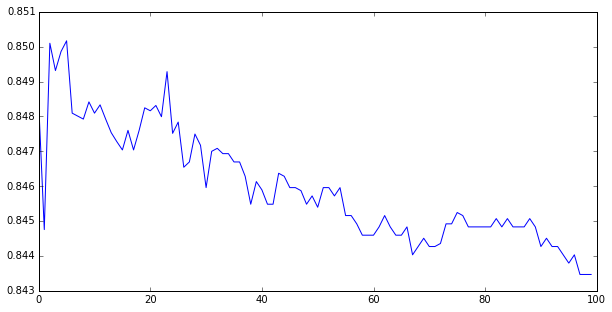

In [17]:
plt.plot(np.arange(len(models)), f1s)

In [18]:
np.argmax(f1s)

5

In [19]:
f1s[:6]

[0.84838442419221216,
 0.84475524475524466,
 0.85009806668534604,
 0.84931506849315075,
 0.8498599439775909,
 0.85016835016835024]

In [20]:
pred = predict_ensemble(get_best_models(6), Xval)
pred[pred < .5] = 0
pred[pred > .5] = 1

f1_score(yval, pred, average='micro')

0.85016835016835024

# Test data time!

In [21]:
pred = predict_ensemble(get_best_models(6), Xtest)

pred[pred < .5] = 0
pred[pred > .5] = 1
labels = mlb.inverse_transform(pred)
labels_str = [' '.join(map(str, l)) for l in labels]
results = pd.DataFrame({'business_id': dataTest.index, 'labels': pd.Series(labels_str)})
results.head()

,business_id,labels
0,003sg,1 2 3 5 6 8
1,00er5,1 2 3 5 6 8
2,00kad,1 2 3 5 6 8
3,00mc6,1 2 5 6
4,00q7x,1 2 4 5 6 7


In [22]:
results.to_csv('results/third_ensemble_val8501.csv', index=False)

# RESULT

LB SCORE: 0.81837

In [25]:
pred = predict_ensemble(get_best_models(5), Xtest)

pred[pred < .5] = 0
pred[pred > .5] = 1
labels = mlb.inverse_transform(pred)
labels_str = [' '.join(map(str, l)) for l in labels]
results = pd.DataFrame({'business_id': dataTest.index, 'labels': pd.Series(labels_str)})
results.head()

,business_id,labels
0,003sg,1 2 3 5 6 8
1,00er5,1 2 3 5 6 8
2,00kad,1 2 3 5 6 8
3,00mc6,1 2 5 6
4,00q7x,1 2 3 4 5 6 7


In [26]:
results.to_csv('results/third_ensemble_5models.csv', index=False)